# Heart Failure Prediction - MLP - PSO

In [1]:
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier
import numpy as np
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [2]:
#https://www.kaggle.com/fedesoriano/heart-failure-prediction
df = pd.read_csv ('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Pré-processamento

In [3]:
#Checar status e tipos de variáveis
df.info()
print('\n')
print(df.shape)
print('\n')
#Chegar se existe observações duplicadas. Não existem observações duplicadas.
print("Qunatidade de dados duplicados", len(df[df.duplicated()]))
#Não existe dados ausentes
print("Qunatidade de dados 'NA':", df.isna().sum().sum())
print('\n')
# Tipos dos dados
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


(918, 12)


Qunatidade de dados duplicados 0
Qunatidade de dados 'NA': 0




Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
# Descrição dos dados não-string
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
# Nota-se que as variáveis 'FastingBS' e 'HeartDisease' são categóricas
print(df['FastingBS'].unique())
print(df['HeartDisease'].unique())

[0 1]
[0 1]


In [6]:
# Transformar as duas variáveis categóricas 'FastingBS' e 'HeartDisease' numéricas para string
df['FastingBS'] = df['FastingBS'].astype(str)
df['HeartDisease'] = df['HeartDisease'].astype(str)

# A transformação acima apenas foi usada para separar os nomes das colunas entre numéricas não-categóricas 
# e categóricas (apenas no formato string - objeto)
num_cols = [col for col in df.columns if df[col].dtype != "object"]
cat_cols = [col for col in df.columns if col not in num_cols]

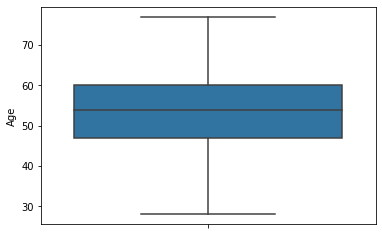

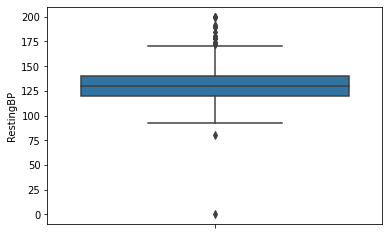

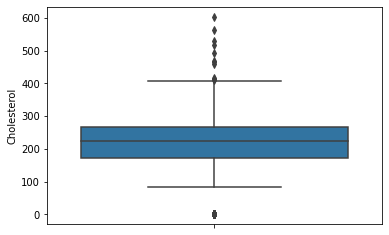

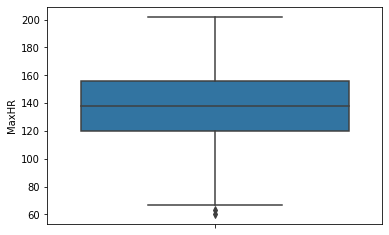

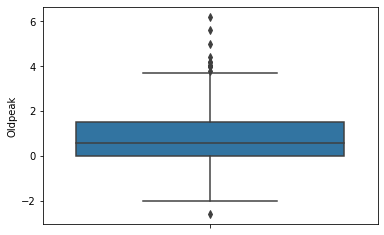

In [7]:
# Detectar outliers de variáveis não-categóricas
for col in num_cols:
    sns.boxplot(y = col , data = df)
    plt.show()

In [8]:
# Detectar outliers de variáveis categóricas
for col in cat_cols:
    print("Variável: "+col+" -> ",df[col].unique())
    print('\n')

Variável: Sex ->  ['M' 'F']


Variável: ChestPainType ->  ['ATA' 'NAP' 'ASY' 'TA']


Variável: FastingBS ->  ['0' '1']


Variável: RestingECG ->  ['Normal' 'ST' 'LVH']


Variável: ExerciseAngina ->  ['N' 'Y']


Variável: ST_Slope ->  ['Up' 'Flat' 'Down']


Variável: HeartDisease ->  ['0' '1']




### Análise de Outliers e Imputação de Dados

####  As variáveis não-categóricas 'RestingBP' e 'Cholesterol' apresentam outliers "estranhos".

In [9]:
# A variável 'RestingBP', que guarda dados sobre pressão sanguínea, possui um valor com pressão zero
# Esse valor não faz sentido
print(len(df[df['RestingBP']==0]))

row = df[df['RestingBP']==0].index
df = df.drop(df.index[row])

1


In [10]:
# Muitos dados da variável 'Cholesterol' apresentam valor de colesterol zero.
# É estranho esse dado. Alguma pessoa viva tem colesterol zero? 
print(len(df[df['Cholesterol']==0]))

# Será usado o método de imputação IQR = Q3 – Q1 
# Os dados da variável 'Cholesterol' será substituida
# pelo número aleatório entre o limite inferior (Q1) e o limite superior(Q3).
IQR = np.percentile(df["Cholesterol"],75) - np.percentile(df["Cholesterol"],25)
lower_bound = np.percentile(df["Cholesterol"],25) - 1.5 * IQR
upper_bound = np.percentile(df["Cholesterol"],75) + 1.5 * IQR
median_cholesterol = np.median(df["Cholesterol"])

df["Cholesterol"] = np.where(((df["Cholesterol"] > upper_bound) | (df["Cholesterol"] < lower_bound)) 
                                 ,random.randint(int(np.percentile(df["Cholesterol"],25)),
                                                 int(np.percentile(df["Cholesterol"],75))),df["Cholesterol"])


'''
median_values = df['Cholesterol'].median()
row = df[df['Cholesterol']==0].index
df.loc[row, 'Cholesterol'] = median_values
'''

171


"\nmedian_values = df['Cholesterol'].median()\nrow = df[df['Cholesterol']==0].index\ndf.loc[row, 'Cholesterol'] = median_values\n"

### Encoding - Variáveis Categóricas

In [11]:
# Mudando variável do tipo string(objeto) para categorico
df['Sex'] = df['Sex'].astype('category')
df['ChestPainType'] = df['ChestPainType'].astype('category')
df['FastingBS'] = df['FastingBS'].astype('category')
df['RestingECG'] = df['RestingECG'].astype('category')
df['ExerciseAngina'] = df['ExerciseAngina'].astype('category')
df['ST_Slope'] = df['ST_Slope'].astype('category')

# Retorna os dados da variável target 'HeartDisease' para o seu tipo original.
df['HeartDisease'] = df['HeartDisease'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             917 non-null    int64   
 1   Sex             917 non-null    category
 2   ChestPainType   917 non-null    category
 3   RestingBP       917 non-null    int64   
 4   Cholesterol     917 non-null    int64   
 5   FastingBS       917 non-null    category
 6   RestingECG      917 non-null    category
 7   MaxHR           917 non-null    int64   
 8   ExerciseAngina  917 non-null    category
 9   Oldpeak         917 non-null    float64 
 10  ST_Slope        917 non-null    category
 11  HeartDisease    917 non-null    int32   
dtypes: category(6), float64(1), int32(1), int64(4)
memory usage: 52.8 KB


In [12]:
# Biblioteca LabelEncoder - sklearn -> para a cadificação dos tipos categoricos.
for i in df:
    labelencoder= LabelEncoder()
    
    if df[i].dtype.name == "category":
        # Codificando e substituindo
        df[i] = labelencoder.fit_transform(df[i])
        
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [13]:
# Normalizando os Dados
df=(df-df.min())/(df.max()-df.min())

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0.244898,1.0,0.333333,0.500000,0.639498,0.0,0.5,0.788732,0.0,0.295455,1.0,0.0
1,0.428571,0.0,0.666667,0.666667,0.297806,0.0,0.5,0.676056,0.0,0.409091,0.5,1.0
2,0.183673,1.0,0.333333,0.416667,0.620690,0.0,1.0,0.267606,0.0,0.295455,1.0,0.0
3,0.408163,0.0,0.000000,0.483333,0.404389,0.0,0.5,0.338028,1.0,0.465909,0.5,1.0
4,0.530612,1.0,0.666667,0.583333,0.344828,0.0,0.5,0.436620,0.0,0.295455,1.0,0.0


## MLP  -  GridSearch / PSO

In [14]:
# Pegando todas as colunas exceto a coluna target - 'HeartDisease'
# Transformando no formato numpy
x_data = df.loc[:, df.columns != 'HeartDisease'].to_numpy() 
# Transformando a coluna 'HeartDisease' para o formato numpy
y_data = df['HeartDisease'].to_numpy()

In [15]:
# Distribuição dos valores 'HeartDisease'
df['HeartDisease'].value_counts()

1.0    507
0.0    410
Name: HeartDisease, dtype: int64

In [16]:
# Utilizando apenas conjunto de treino e teste.
# No knn não faz sentindo ter validação.
X_train, X_test, y_train, y_test =  train_test_split(x_data, y_data , random_state=1, test_size=.25)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(687, 11) (687,) (230, 11) (230,)


### GridSearch

In [18]:
mlp = MLPClassifier(max_iter=1000)

params = {
    'hidden_layer_sizes': [(32,32), (32,64), (64,128)],
    'activation': ['tanh', 'relu'],
    'solver':['sgd','adam'],
    'alpha':[0.0001, 0.05],
    'learning_rate': ['constante','adaptive'],
}

gridS = GridSearchCV(mlp,params,n_jobs=-1,cv=3)
grid_result = gridS.fit(X_train,y_train)

grid_result.best_params_

C:\Users\John\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.84133916 0.84570597        nan        nan
 0.84279476 0.84133916        nan        nan 0.84425036 0.84279476
        nan        nan 0.84133916 0.8558952         nan        nan
 0.83988355 0.84716157        nan        nan 0.84279476 0.84716157
        nan        nan 0.83842795 0.82387191        nan        nan
 0.83551674 0.81513828        nan        nan 0.83406114 0.80931587
        nan        nan 0.83988355 0.84279476        nan        nan
 0.84425036 0.82969432        nan        nan 0.84279476 0.83114993]
  warnings.warn(
C:\Users\John\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh',
 'alpha': 0.05,
 'hidden_layer_sizes': (32, 32),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=grid_result.best_params_['hidden_layer_sizes'], 
                    activation=grid_result.best_params_['activation'], solver=grid_result.best_params_['solver'],
                    alpha=grid_result.best_params_['alpha'],
                    learning_rate=grid_result.best_params_['learning_rate'], max_iter=1000)

mlp.fit(X_train, y_train)

print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81        97
         1.0       0.86      0.85      0.86       133

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.84      0.83      0.83       230



C:\Users\John\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### PSO

In [28]:
# Função fitness
def fitness(p,X_train,y_train,X_test,y_test):

# p é a matriz com os valores dos bounds
    if int(p[0,2])==1:
        activation = 'tanh'
    else:
        activation = 'relu'
    
    if int(p[0,3])==1:
        solver = 'sgd'
    else:
        solver = 'adam'
        
    if int(p[0,4])==1:
        alpha = 0.0001
    else:
        alpha = 0.05
        
    if int(p[0,5])==1:
        learning_rate = 'constante'
    else:
        learning_rate = 'adaptive'
        
    mlp = MLPClassifier(hidden_layer_sizes=(int(p[0,0]),int(p[0,1])), 
                    activation=activation, solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate, max_iter=1000)
    mlp.fit(X_train, y_train)

    # Buscando a acurácia
    acc = classification_report(y_test, mlp.predict(X_test), output_dict=True)['accuracy']
    # A acurácia (acc) é uma função linear que varia de 0% a 100%. Logo o seu mínimo é 0% e o seu mínimo representa o
    # pior caso. No entanto, queremos o melhor caso -> tendência para 100%
    # Como o PSO trabalha referenciando o mínimo da função como o melhor caso, então temos que retornar 1-acc
    # tendência para 100%
    return 1-acc 

# Limites da fronteira do PSO -> são os hiperparâmetros de MLP que serão referênciados na função fitness
# Note que na função fitness estamos considerando 5 hiperparâmetros - note a função MLPClassifier()
max_bound = np.array([128,128,3,3,3,3])
# Menor valor de k 1
min_bound = np.array([8,8,1,1,1,1])
bounds = (min_bound, max_bound)

# Hiperparametros do PSO
options = {'c1': 0.3, 'c2': 0.3, 'w': 0.5}
# Otimizador do PSO
optimizer = GlobalBestPSO(n_particles=10, dimensions=6, options=options, bounds = bounds )
# Buscando os melhores valores para os hiperparâmetros da MLP (pos)
cost, pos = optimizer.optimize(fitness,iters=1000,X_train=X_train ,y_train=y_train,X_test=X_test,y_test=y_test)

2021-11-07 14:41:12,548 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.5}
pyswarms.single.global_best:   0%|                                                             |1/1000, best_cost=0.161C:\Users\John\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|1000/1000, best_cost=0.152
2021-11-07 15:28:44,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.15217391304347827, best pos: [124.73396437 108.73229564   1.41256763   1.87373794   1.08157109
   2.34403469]


In [29]:
print(pos)

[124.73396437 108.73229564   1.41256763   1.87373794   1.08157109
   2.34403469]


In [30]:
if int(pos[2])==1:
    activation = 'tanh'
else:
    activation = 'relu'
    
if int(pos[3])==1:
    solver = 'sgd'
else:
    solver = 'adam'
        
if int(pos[4])==1:
    alpha = 0.0001
else:
    alpha = 0.05
        
if int(pos[5])==1:
    learning_rate = 'constante'
else:
    learning_rate = 'adaptive'

mlp = MLPClassifier(hidden_layer_sizes=(int(pos[0]),int(pos[1])), 
                    activation=activation, solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate, max_iter=1000)

mlp.fit(X_train, y_train)

print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81        97
         1.0       0.87      0.83      0.85       133

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.84      0.83      0.84       230

